# test.fa に対する結果の図示

In [ ]:
import subprocess
import matplotlib.pyplot as plt

# 実行時変数
EXE = "..\\a.exe"
IN_FILE = "../../CapR/test.fa"
OUT_FILE = "../test/out.txt"

def run_command(beam_size):
	command_state = f"{EXE} {IN_FILE} {OUT_FILE} {beam_size}"
	cp = subprocess.run(command_state, shell=True, capture_output=True, text=True)
	print(cp.stdout)
	print(cp.stderr)

In [ ]:
def parse_output(out_file):
	structures = []
	probs = []
	with open(out_file, "r") as f:
		seq_name = f.readline()[1:]
		print(seq_name)
		for line in f:
			data = line.split()
			if len(data) == 0: continue
			structures.append(data[0])
			probs.append(list(map(float, data[1:])))
	return structures, probs

In [ ]:
def show_graph(s, p, x1, x2):
	for i in range(len(s)):
		plt.plot(range(len(p[i])), p[i], label=s[i])

	plt.xlabel("nucleotide position")
	plt.ylabel("probability")
	# plt.ylim(-0.1, 1.1)
	plt.xlim(x1, x2)
	plt.legend(bbox_to_anchor=(1, 1),loc="upper left",fontsize=12)
	plt.show()

In [ ]:
s, p = parse_output("../../NC_045512.sprof")
show_graph(s, p, 250, 300)
# show_graph(*parse_output("../../out_CapR/bpRNA_RFAM_32074.sprof"), 0, 90)

In [ ]:
res = ""
for i in range(len(p)):
	for j in range(len(p[0])):
		if p[i][j] < -0.1:
			res += f"{i}, {j}: {p[i][j]:10.6f}\n"
print(res)

In [ ]:
s, p = parse_output("../../dataset/out_CapR/debug.txt")
show_graph(s, p, 0, 60)

In [ ]:
beam = [5, 10, 20, 30, 40, 50, 100, 0]
for b in beam:
	run_command(b)
	print(b)
	s, p = parse_output(OUT_FILE)
	x = []
	for i in range(len(p[0])):
		p_sum = 0
		for j in range(len(s)):
			p_sum += p[j][i]
		x.append(p_sum)
	print(x)

	

# データセット準備

In [ ]:
# 
import glob

NUM_FILE = 1000

# ファイル一覧取得
files = glob.glob("./images/*")

# 

# 実行

# 解析

## 実行時間

## 精度

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
import json

In [2]:
def to_onehot(ans):
    res = np.zeros((6, len(ans)), dtype=int)
    for i in range(len(ans)):
        res[ans[i]][i] = 1
    return res

In [3]:
STRUCTURES = ["Bulge", "Exterior", "Hairpin", "Internal", "Multibranch", "Stem"]

In [4]:
def load_pa(filename):
	with open(filename, "r") as f:
		pa = json.load(f)
	return pa

In [15]:
BEAM_SIZES = [100, 200, 400]
pa_lcr, pa_cr = {}, {}
for b in BEAM_SIZES:
	pa_lcr[b] = load_pa(f"../../lcr_{b}.json")
	pa_cr[b] = load_pa(f"../../cr_{b}.json")

In [25]:
pa_lcr_l_100 = load_pa(f"../../lcr_l.json")

In [27]:
pa_lcr_l2_100 = load_pa(f"../../lcr_l2.json")

In [7]:
def fpr_tpr(prof, ans):
	fpr, tpr, ra = {}, {}, {}
	for i in range(6):
		fpr[i], tpr[i], _ = roc_curve(ans[i], prof[i])
		ra[i] = auc(fpr[i], tpr[i])

	fpr_grid = np.linspace(0.0, 1.0, 1000)

	mean_tpr = np.zeros_like(fpr_grid)

	for i in range(6):
		mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

	mean_tpr /= 6

	fpr["macro"] = fpr_grid
	tpr["macro"] = mean_tpr
	ra["macro"] = auc(fpr["macro"], tpr["macro"])

	return fpr, tpr, ra

In [8]:
def extract_pa(pa, len_mi = 0, len_ma = 1e9):
	prof = [[] for _ in range(6)]
	ans = [[] for _ in range(6)]
	for key, value in pa.items():
		len_seq = len(value[1])
		if len_seq < len_mi or len_ma < len_seq: continue
		onehot = to_onehot(value[1])
		for i in range(6):
			prof[i].extend(list(map(float, value[0][i])))
			ans[i].extend(onehot[i])
	return prof, ans

In [29]:
def auc_roc(ax, prof, ans, title):
	fpr, tpr, ra = fpr_tpr(prof, ans)

	# byouga
	for i in range(6):
		ax.plot(fpr[i], tpr[i], label=f"{STRUCTURES[i]}")
	ax.plot(fpr["macro"], tpr["macro"], label=f"macro", lw=4)
	
	# ax.legend(bbox_to_anchor=(1, 1),loc="upper left",fontsize=20)
	ax.set_title(title)
	ax.set_xlabel("FPR")
	ax.set_ylabel("TPR")
	ax.set_aspect("equal")
	#  (AUC = {ra[i]:.2f})

In [30]:
ex_lcr_l_100 = extract_pa(pa_lcr_l_100)
ex_lcr_l2_100 = extract_pa(pa_lcr_l2_100)


In [37]:
ex_lcr_l_100_l100 = extract_pa(pa_lcr_l_100, 0, 100)
ex_lcr_l2_100_l100 = extract_pa(pa_lcr_l2_100, 0, 100)
ex_cr_100_l100 = extract_pa(pa_cr[100], 0, 100)

In [56]:
show_dict(fpr_tpr(*ex_lcr_l_100)[2])
show_dict(fpr_tpr(*ex_lcr_l2_100)[2])
show_dict(fpr_tpr(*ex_lcr[100, 0])[2])
show_dict(fpr_tpr(*ex_cr[100, 0])[2])

0: 0.684
1: 0.881
2: 0.788
3: 0.717
4: 0.770
5: 0.769
macro: 0.768
0: 0.684
1: 0.881
2: 0.788
3: 0.717
4: 0.770
5: 0.769
macro: 0.768
0: 0.703
1: 0.883
2: 0.785
3: 0.733
4: 0.798
5: 0.777
macro: 0.780
0: 0.679
1: 0.823
2: 0.776
3: 0.712
4: 0.749
5: 0.762
macro: 0.750


In [35]:
LIMITS = [0, 2000, 2500, 3000, 3500]
ex_lcr, ex_cr = {}, {}
for b in BEAM_SIZES:
	for l in LIMITS:
		ex_lcr[b, l] = extract_pa(pa_lcr[b], l)
		ex_cr[b, l] = extract_pa(pa_cr[b], l)

In [11]:
def show_dict(d):
	for key, value in d.items():
		print(f"{key}: {value:.3f}")

In [22]:
for i in range(len(BEAM_SIZES)):
	print(f"CR {BEAM_SIZES[i]}:")
	show_dict(fpr_tpr(*ex_cr[BEAM_SIZES[i], 0])[2])
	print(f"LCR {BEAM_SIZES[i]}:")
	show_dict(fpr_tpr(*ex_lcr[BEAM_SIZES[i], 0])[2])

CR 100:
0: 0.679
1: 0.823
2: 0.776
3: 0.712
4: 0.749
5: 0.762
macro: 0.750
LCR 100:
0: 0.703
1: 0.883
2: 0.785
3: 0.733
4: 0.798
5: 0.777
macro: 0.780
CR 200:
0: 0.695
1: 0.841
2: 0.788
3: 0.726
4: 0.783
5: 0.773
macro: 0.768
LCR 200:
0: 0.706
1: 0.884
2: 0.785
3: 0.735
4: 0.807
5: 0.778
macro: 0.782
CR 400:
0: 0.690
1: 0.856
2: 0.789
3: 0.725
4: 0.793
5: 0.774
macro: 0.771
LCR 400:
0: 0.706
1: 0.885
2: 0.785
3: 0.735
4: 0.812
5: 0.778
macro: 0.784


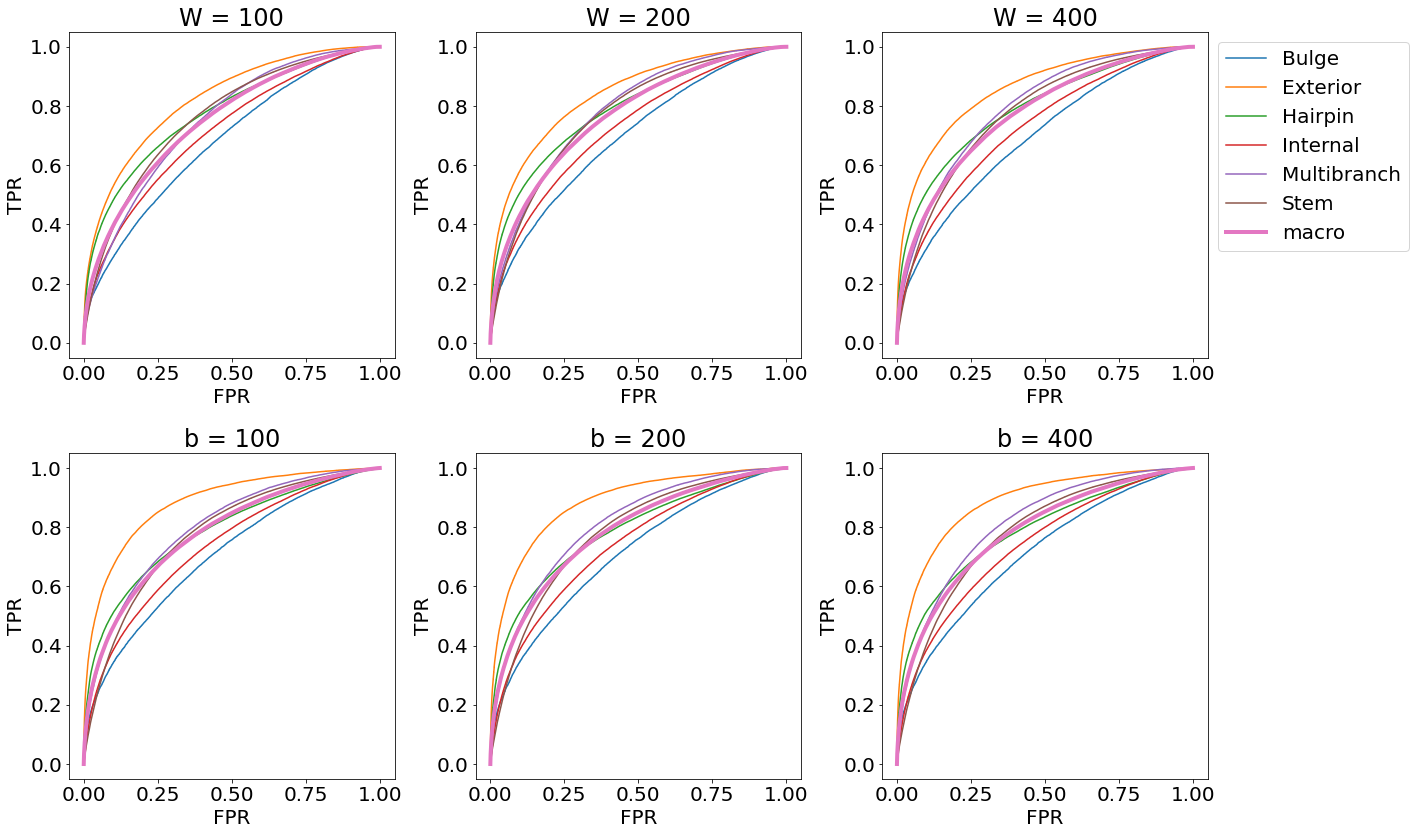

In [24]:
plt.rcParams["font.size"] = 20
fig = plt.figure(figsize = (20,12))
axes = fig.subplots(2, 3)
for i in range(len(BEAM_SIZES)):
	auc_roc(axes[0][i], *ex_cr[BEAM_SIZES[i], 0], f"W = {BEAM_SIZES[i]}")
	auc_roc(axes[1][i], *ex_lcr[BEAM_SIZES[i], 0], f"b = {BEAM_SIZES[i]}")

axes[0][2].legend(bbox_to_anchor=(1, 1),loc="upper left",fontsize=20)
plt.tight_layout()
fig.savefig("rocauc.png")

In [54]:
def auc_roc_split(lcr, cr):
	fpr_lcr, tpr_lcr, ra_lcr = fpr_tpr(*lcr)
	fpr_cr, tpr_cr, ra_cr = fpr_tpr(*cr)
	
	plt.rcParams["font.size"] = 20
	fig = plt.figure(figsize = (20,12))
	# for i in range(6):
	# 	ax = fig.add_subplot(2, 4, i + 1)
	# 	ax.plot(fpr_lcr[i], tpr_lcr[i], label=f"LinCapR")
	# 	ax.plot(fpr_cr[i], tpr_cr[i], label=f"CapR", color="gray")
	# 	ax.set_title(STRUCTURES[i])
	# 	ax.set_aspect("equal")
	# 	ax.set_xlabel("FPR")
	# 	ax.set_ylabel("TPR")

	ax = fig.add_subplot(2, 4, 7)
	ax.plot(fpr_lcr["macro"], tpr_lcr["macro"], label=f"LinCapR")
	ax.plot(fpr_cr["macro"], tpr_cr["macro"], label=f"CapR", color="gray")
	# ax.set_title("Macro Avg.")
	# ax.set_aspect("equal")
	# ax.set_xlabel("FPR")
	# ax.set_ylabel("TPR")
	ax.legend(bbox_to_anchor=(1, 0),loc="lower left",fontsize=20)
	plt.tight_layout()
	# fig.savefig("rocauc.png")
	plt.show()

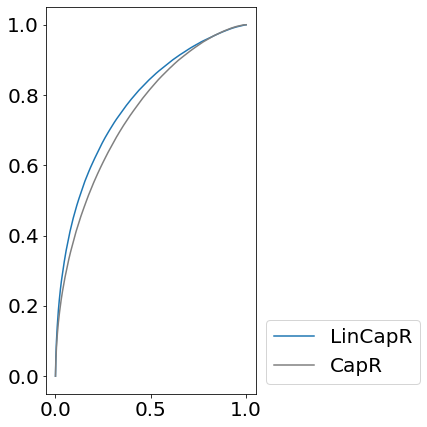

In [55]:
auc_roc_split(ex_lcr[100, 0], ex_cr[100, 0])

In [98]:
# def lenmima(pa):
# 	mi, ma = 1e9, 0
# 	for key, value in pa.items():
# 		len_seq = len(value[1])
# 		if mi > len_seq: mi = len_seq
# 		if ma < len_seq: ma = len_seq
# 	return mi, ma

In [99]:
# lenmima(pa_lcr_100)

(19, 4021)

In [ ]:
# def auc_roc(name, out_prefix, ans_prefix):
#     _, p = load_prof(out_prefix + name + ".sprof")
#     ans = load_ans(ans_prefix + name + ".strc")

#     # normalize(p)
#     # print(len(ans), len(p.sum(axis=0)))
#     # auroc = roc_auc_score(ans, p.T, multi_class="ovr", average="macro")
#     # print(auroc)

#     ans_onehot = to_onehot(ans)
#     for i in range(len(p)):
#         fpr, tpr, _ = roc_curve(ans_onehot[:, i], p[i])
#         auc_score = auc(fpr, tpr)
#         plt.plot(fpr, tpr, label=f"{STRUCTURES[i]} (AUC = {auc_score:.2f})")

#     plt.xlabel("FPR")
#     plt.ylabel("TPR")
#     plt.legend(bbox_to_anchor=(1, 1),loc="upper left",fontsize=12)
#     plt.show()

In [ ]:
# auc_roc("bpRNA_RFAM_32074", "../../", "../../")

# RNACentral データ取得

In [ ]:
import requests
from bs4 import BeautifulSoup

In [ ]:
def get_bin_num(len_mi, len_ma):
	params = {"q": "RNA AND length:[{len_mi} TO {len_ma}]"}
	res = requests.get("https://rnacentral.org/search", params)
	soup = BeautifulSoup(res.text, "lxml")
	# ret = soup.select("#text-search-results-count")
	ret = soup.select_one("#ng-app")
	print(ret)

In [ ]:
get_bin_num(4000, 5000)